In [1]:
!nvidia-smi

Sat Nov 11 00:17:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|100%   88C    P2   218W / 350W |   9701MiB / 24576MiB |     83%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 88%   

In [ ]:
!git clone --branch ta-ocr https://github.com/Syun1208/ocr-tma

Cloning into 'ocr-tma'...
remote: Enumerating objects: 9928, done.
remote: Counting objects: 100% (2455/2455), done.
remote: Compressing objects: 100% (1789/1789), done.
remote: Total 9928 (delta 576), reused 2444 (delta 572), pack-reused 7473
Receiving objects: 100% (9928/9928), 291.27 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (1416/1416), done.


# Load datasets from Huggingface Community

In [ ]:
# Get datasets from cloud: huggingface community
!git clone https://huggingface.co/datasets/naver-clova-ix/cord-v1

Cloning into 'cord-v1'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), 4.11 KiB | 601.00 KiB/s, done.
Filtering content: 100% (6/6), 2.14 GiB | 61.79 MiB/s, done.


In [ ]:
import pandas as pd
train_path = ["/content/cord-v1/data/train-00000-of-00004-4ecdadef88e06e74.parquet"]
df = pd.read_parquet(train_path)
df

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."
...,...,...
195,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""CRISPY APPLE RA..."
196,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""PEPPERONI"", ""un..."
197,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""CK.MANTAP A"", ""..."
198,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""TARO"", ""cnt"": ""1..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         200 non-null    object
 1   ground_truth  200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [ ]:
df.isna().sum()

image           0
ground_truth    0
dtype: int64

In [ ]:
import pyarrow.parquet as pq
import os
import sys
import glob
import tqdm
import json


def get_images_from_lfs(path_read: str):

    table = pq.read_table(path_read)
    save_datasets_dir = '/content/datasets/'
    os.makedirs(save_datasets_dir, exist_ok=True)
    splited_datasets_save = os.path.join(save_datasets_dir, path_read.split('/')[-1].split('-')[0])
    os.makedirs(splited_datasets_save, exist_ok=True)
    save_labels_dir = '/content/labels/'
    os.makedirs(save_labels_dir, exist_ok=True)
    splited_labels_save = os.path.join(save_labels_dir, path_read.split('/')[-1].split('-')[0])
    os.makedirs(splited_labels_save, exist_ok=True)

    index = 0
    for img in table['image']:
        b = img['bytes'].as_py()
        with open(os.path.join(splited_datasets_save, f'{index}.png'), 'wb') as f_datasets:
            f_datasets.write(b)
            index+=1

    index = 0
    for label in table['ground_truth']:
        converted_json = str(label)
        with open(os.path.join(splited_labels_save, f'{index}.json'), 'w') as f_labels:
            f_labels.write(converted_json)
            index+=1
    f_datasets.close()
    f_labels.close()

In [ ]:
ROOT = os.getcwd()
WORK_DIR = os.path.dirname(ROOT)

lfs_dir = sorted(glob.glob('/content/cord-v1/data/*.parquet'))

for parquet in tqdm.tqdm(lfs_dir, colour='red', desc='Extracting datasets from cloud'):
    get_images_from_lfs(parquet)


Extracting datasets from cloud: 100%|██████████| 6/6 [00:22<00:00,  3.74s/it]


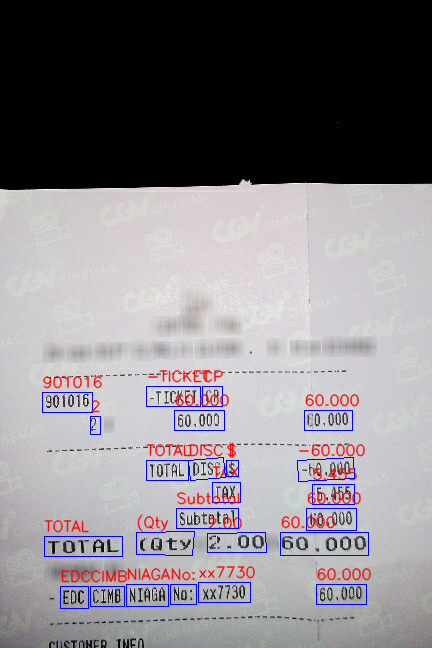

In [ ]:
# Visualize datasets

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import cv2
import numpy as np
from IPython.display import Image, display



json_path = '/content/labels/test/0.json'
image_path = '/content/datasets/test/0.png'

with open(json_path, 'r') as f:
    json_data = json.loads(f.read())

image_width = json_data["meta"]["image_size"]["width"]
image_height = json_data["meta"]["image_size"]["height"]


words_info = json_data["valid_line"]


image_size = (image_width, image_height)
image = cv2.imread(image_path)

for word_info in words_info:
    for word in word_info["words"]:
        x1, y1 = int(word["quad"]["x1"]), int(word["quad"]["y1"])
        x2, y2 = int(word["quad"]["x2"]), int(word["quad"]["y2"])
        x3, y3 = int(word["quad"]["x3"]), int(word["quad"]["y3"])
        x4, y4 = int(word["quad"]["x4"]), int(word["quad"]["y4"])


        cv2.polylines(image, [np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.int32)], isClosed=True,
                      color=(255, 0, 0), thickness=1)


        cv2.putText(image, word["text"], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)


display(Image(data=bytes(cv2.imencode('.png', image)[1]), format='png'))


# Data Preprocessing

In [ ]:
# Data preprocessing
'''
p1,p2,p3,p4,p5,p6,p7,p8,w
'''
import glob
import shutil
from IPython.display import clear_output

def copy_images(source_folder, destination_folder):
    """
    Copy image files from the source folder to the destination folder.

    Args:
        source_folder (str): The path to the source folder containing image files.
        destination_folder (str): The path to the destination folder where images will be copied.
    """
    # Ensure the destination folder exists, or create it if it doesn't
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get a list of image files in the source folder
    image_files = [f for f in os.listdir(source_folder) if f.endswith((".jpg", ".png", ".gif", ".bmp", ".jpeg"))]

    # Loop through the image files and copy them to the destination folder
    for image_file in image_files:
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(destination_folder, image_file)

        # Copy the image file to the destination folder
        shutil.copy2(source_path, destination_path)


class DataPreprocessing:
    '''
    Folder trees:

      - datasetes_dir:

        /content/datasets
        .
        ├── test
        ├── train
        └── validation

      - annotation_dir:
        /content/labels
        .
        ├── test
        ├── train
        └── validation
    '''
    def __init__(self, datasets_dir, annotation_dir):
        self.datasets_dir = datasets_dir
        self.annotation_dir = annotation_dir
        self.list_folder_images = os.listdir(self.datasets_dir)
        self.list_folder_labels = os.listdir(self.annotation_dir)

    def data_recognition(self):

      for type_folder in tqdm.tqdm(self.list_folder_images, desc='Converting to CRNN Labels: ', colour='green'):

        clear_output(wait=True)

        abs_folder_images = os.path.join(self.datasets_dir, type_folder)
        abs_folder_labels = os.path.join(self.annotation_dir, type_folder)

        folder_crnn = '/content/naver-clova-ix-rec/'
        os.makedirs(folder_crnn, exist_ok=True)
        folder_crnn_images = os.path.join(folder_crnn, f'{type_folder}_img/')
        os.makedirs(folder_crnn_images, exist_ok=True)

        for json_path in os.listdir(abs_folder_labels):
          abs_json_path = os.path.join(abs_folder_labels, json_path)
          image = cv2.imread(os.path.join(abs_folder_images, json_path.replace('json', 'png')))

          if json_path == '114.json' or json_path == '79.json' or json_path == '34.json':
              continue
          with open(abs_json_path, 'r') as f:
              json_data = json.loads(f.read())

          words_info = json_data["valid_line"]

          index=0
          for word_info in words_info:
              for word in word_info["words"]:
                  x1, y1 = int(word["quad"]["x1"]), int(word["quad"]["y1"])
                  x2, y2 = int(word["quad"]["x2"]), int(word["quad"]["y2"])
                  x3, y3 = int(word["quad"]["x3"]), int(word["quad"]["y3"])
                  x4, y4 = int(word["quad"]["x4"]), int(word["quad"]["y4"])


                  top_left_x = min([x1,x2,x3,x4])
                  top_left_y = min([y1,y2,y3,y4])
                  bot_right_x = max([x1,x2,x3,x4])
                  bot_right_y = max([y1,y2,y3,y4])

                  cropped_image = image[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

                  text = word["text"]

                  cv2.imwrite(os.path.join(folder_crnn_images, f'{text}_{index}.jpg'), cropped_image)
                  index = index + 1

      print("Converted successfully!")

    def data_detection(self):

        for type_folder in tqdm.tqdm(self.list_folder_images, desc='Converting to EAST Labels: ', colour='green'):

            clear_output(wait=True)

            abs_folder_images = os.path.join(self.datasets_dir, type_folder)
            abs_folder_labels = os.path.join(self.annotation_dir, type_folder)

            folder_east = '/content/naver-clova-ix-det/'
            os.makedirs(folder_east, exist_ok=True)
            folder_east_images = os.path.join(folder_east, f'{type_folder}_img/')
            os.makedirs(folder_east_images, exist_ok=True)
            folder_east_labels = os.path.join(folder_east, f'{type_folder}_gt/')
            os.makedirs(folder_east_labels, exist_ok=True)

            copy_images(abs_folder_images, folder_east_images)

            for json_path in os.listdir(abs_folder_labels):
              abs_json_path = os.path.join(abs_folder_labels, json_path)
              file_east_label = open(os.path.join(folder_east_labels, os.path.splitext(abs_json_path.split('/')[-1])[0] + '.txt'), 'w+')
              with open(abs_json_path, 'r') as f:
                  json_data = json.loads(f.read())

              words_info = json_data["valid_line"]

              for word_info in words_info:
                  for word in word_info["words"]:
                      x1, y1 = int(word["quad"]["x1"]), int(word["quad"]["y1"])
                      x2, y2 = int(word["quad"]["x2"]), int(word["quad"]["y2"])
                      x3, y3 = int(word["quad"]["x3"]), int(word["quad"]["y3"])
                      x4, y4 = int(word["quad"]["x4"]), int(word["quad"]["y4"])

                      file_east_label.write(f'{x1},{y1},{x2},{y2},{x3},{y3},{x4},{y4},{word["text"]}\n')


        print("Converted successfully!")

# Text Detection:
*  EAST: An Efficient and Accurate Scene Text Detector.

In [ ]:
%cd /content/ocr-tma/utils/EAST/
!bash get_pretrained_model.sh

/content/ocr-tma/utils/EAST
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HgDuFGd2q77Z6DcUlDEfBZgxeJv4tald
To: /content/ocr-tma/utils/EAST/pths/vgg16_bn-6c64b313.pth
100% 554M/554M [00:06<00:00, 83.8MB/s]


In [ ]:
# Data Preprocessing

path_images = '/content/datasets/'
path_labels = '/content/labels/'

data_preprocessing = DataPreprocessing(datasets_dir=path_images, annotation_dir=path_labels)
data_preprocessing.data_detection()

Converting to EAST Labels: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

Converted successfully!


In [ ]:
!mv /content/naver-clova-ix-det /content/ocr-tma/data

In [ ]:
!pip install lamb

In [ ]:
%cd /content/ocr-tma/utils/EAST
!CUDA_VISIBLE_DEVICES=0 python train.py

/content/ocr-tma/utils/EAST
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
classify loss is 0.96181315, angle loss is 0.72965097, iou loss is 4.84246540
Epoch is [1/80], mini-batch is [1/25], time consumption is 7.10874915, batch_loss is 13.10078812
classify loss is 0.96779543, angle loss is 0.65409541, iou loss is 4.40510082
Epoch is [1/80], mini-batch is [2/25], time consumption is 0.30750060, batch_loss is 11.91384983
classify loss is 0.96793854, angle loss is 0.56142586, iou loss is 3.94221

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mv /content/ocr-tma/utils/EAST/pths/model_epoch_80.pth /content/drive/ta-ocr/

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python eval.py

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python detect.py

# Text Recognition
* Convolutional Recurrent Neural Network (CRNN)

In [ ]:
# Data Preprocessing

path_images = '/content/datasets/'
path_labels = '/content/labels/'

data_preprocessing = DataPreprocessing(datasets_dir=path_images, annotation_dir=path_labels)
data_preprocessing.data_recognition()

Converting to CRNN Labels: 100%|██████████| 3/3 [00:21<00:00,  7.18s/it]

Converted successfully!


In [ ]:
!mv /content/naver-clova-ix-rec /content/ocr-tma/data

In [ ]:
# Download pretrained model
!gdown --id 1VWqypLFKCpuVO2Na5JMQpkeuy_oNptY1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VWqypLFKCpuVO2Na5JMQpkeuy_oNptY1
To: /content/text-recognition/crnn.pth
100% 37.4M/37.4M [00:00<00:00, 39.0MB/s]


In [ ]:
!pip install lmdb

In [ ]:
%cd /content/ocr-tma/utils/CRNN
!python tool/create_dataset.py --out /content/ocr-tma/data/naver-clova-ix-rec/output_train --folder /content/ocr-tma/data/naver-clova-ix-rec/train_img/
!python tool/create_dataset.py --out /content/ocr-tma/data/naver-clova-ix-rec/output_validation --folder /content/ocr-tma/data/naver-clova-ix-rec/validation_img/

/content/ocr-tma/utils/CRNN
/content/ocr-tma/utils/CRNN/tool/create_dataset.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  imageBuf = np.fromstring(imageBin, dtype=np.uint8)
Written 1000 / 4021
Written 2000 / 4021
Written 3000 / 4021
Written 4000 / 4021
Created dataset with 4021 samples

Show some demo to prevent creating wrong lmdb data
The first line is the path to image and the second line is the image label
image: /content/ocr-tma/data/naver-clova-ix-rec/train_img//&_1.jpg
label: &

image: /content/ocr-tma/data/naver-clova-ix-rec/train_img//0_9.jpg
label: 0

/content/ocr-tma/utils/CRNN/tool/create_dataset.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  imageBuf = np.fromstring(imageBin, dtype=np.uint8)
Written 1000 / 1716
Created dataset with 1716 samples

Show some demo to prevent creating wro

In [ ]:
!pip install torch==1.11.0
!pip install torchvision==0.1.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
Reason for being yanked: 0.1.6 is past it's support date and confuses users on unsupported platforms
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstall

In [ ]:
%cd /content/ocr-tma/utils/CRNN
!python train.py

/content/ocr-tma/utils/CRNN
CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d

In [ ]:
%cd /content/text-recognition/crnn-pytorch
!python demo.py -m /content/ocr-tma/utils/CRNN/expr/CRNN_99_250.pth -i /content/ocr-tma/data/naver-clova-ix-rec/test_img/haha.jpg

[Errno 2] No such file or directory: '/content/text-recognition/crnn-pytorch'
/content/ocr-tma/utils/CRNN
loading pretrained model from /content/ocr-tma/utils/CRNN/expr/CRNN_99_250.pth
(--p--u--n--d-iiin--g--)-- => (punding)           


# Evaluation

# Inference

In [ ]:
import sys

sys.path.append('../')

from text_detection.EAST.detect import detector
from text_recognition.CRNN import recognizer

class TextE2E:
    def __init__(self, model_det, model_rec):
        self.model_det = model_det
        self.model_rec = model_rec

    def __call__(self, image, *args, **kwds):
        boxes = detector(image, self.model_det)
        texts = []
        for box in boxes:

            x1, y1, x2, y2, x3, y3, x4, y4 = box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]

            top_left_x = min([x1,x2,x3,x4])
            top_left_y = min([y1,y2,y3,y4])
            bot_right_x = max([x1,x2,x3,x4])
            bot_right_y = max([y1,y2,y3,y4])


            cropped_image = image[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

            text = recognizer(cropped_image)
            texts.append(text)

        return texts


# Operation